<a href="https://colab.research.google.com/github/carlassaraf/pes-utn-fra/blob/main/tp1/pes_tp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico Nº 1

Objetivos:
* Aplicar conceptos de procesamiento de señales en python, como convolución.
* Familiarizarse con el entorno de desarrollo de python notebooks

## Ejercicios
1- Encontrar la función de transferencia del moving average. (Para esto deben definir un algoritmo de moving average y extraer su firma/transferencia).

2- Inyectar al moving average una cuadrada de amplitud 1 y frecuencia 2KHz y una triangular de amplitud 1 y frecuencia 1KHz. Analizar los resultados.

3- Realizar un algoritmo de convolución en float y en punto fijo (por ejemplo usando 'fixedpoint'), comparar tiempos y error a la salida. (Compararlo con np.convolve). Sacar conclusiones sobre los resultados.
Medir tiempos de computo con el método: timeit de la lib timeit de la siguiente forma:

In [3]:
%pylab inline
import timeit
import time
import numpy as np

t = np.arange(0, 1024/20000, 1/20000)
s1= np.sin(2*np.pi*1000*t)+1
s2 = np.sin(2*np.pi*1200*t)

# METODO 1 de medición de tiempos

# Este wrapper empaqueta funciones para que el timeit pueda medir solo eso
def wrapper(func, *args):
    def wrapped():
        return func(*args)
    return wrapped

conv = wrapper(np.convolve, s1, s2)
print (timeit.timeit(conv, number=1))

# METODO 2 de medición de tiempos
start = time.time()
conv_r = np.convolve(s1,s2)
end = time.time()
print (end-start)



Populating the interactive namespace from numpy and matplotlib
0.0003742920000036065
0.0005059242248535156


### Simple Moving Average (SMA)

$$
\frac{1}{k} \sum_{i=n-k+1}^{n} p_i
$$

La diferencia en la medición depende de la carga de la CPU y que el primer método mide solamente la función pedida. Usar uno de los 2 para realizar la medición, como la medición es comparativa, solo importa usar el mismo método para todo, los valores absolutos no importan.

In [4]:
#1- Encontrar la función de transferencia del moving average. (Para esto deben definir un algoritmo de moving average y extraer su firma/transferencia).
import numpy as np
import matplotlib.pyplot as plt


def moving_average(signal : list, window_size : int) -> list:
  """Funcion que calcula el moving average de una señal

  Parameters
  ----------
  signal : list
    Valores de la señal a analizar

  window_size : int
    Tamaño de la ventana

  Returns
  -------
  list
    Lista con el moving average de la señal
  """

  # Lista para devolver
  out = []

  for i, _ in enumerate(signal):
    # Verifico que puedo analizar una ventana entera
    if len(signal) - i >= window_size:
      # Calculo el promedio de la ventana actual
      window_average = np.sum(signal[i:i+window_size]) / window_size
      # Pongo el promedio en la lista
      out.append(window_average)
    else:
      # Ya no se puede analizar mas la ventana
      return out

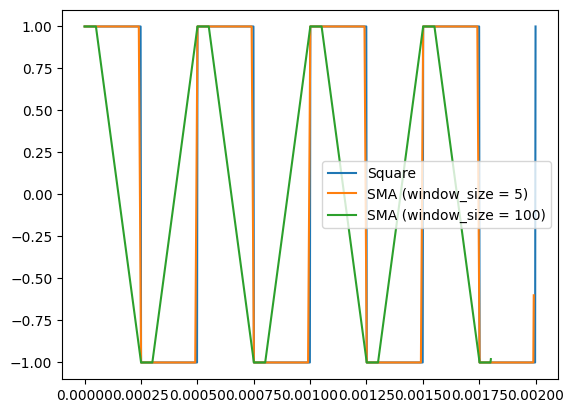

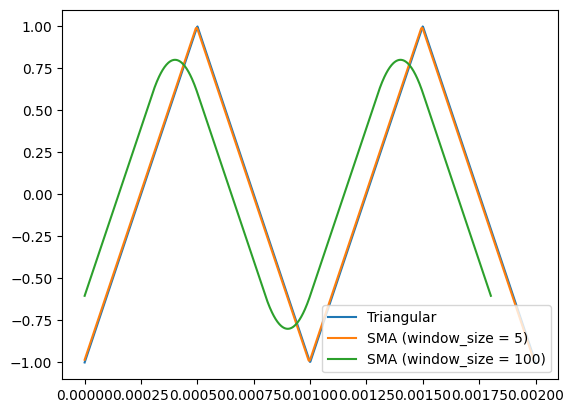

In [5]:
#2- Inyectar al moving average una cuadrada de amplitud 1 y frecuencia 2KHz y una triangular de amplitud 1 y frecuencia 1KHz.
#   Analizar los resultados.

import scipy.signal as sig

window_size_1 = 5
window_size_2 = 100

# Puntos para calcular
t = np.linspace(0, 2e-3, 1000)
# Puntos de y para la cuadrada
y_square = sig.square(2 * np.pi * t * 2000)

plt.plot(t, y_square, label="Square")
plt.plot(t[:len(t) - window_size_1 + 1], moving_average(y_square, window_size_1), label=f"SMA (window_size = {window_size_1})")
plt.plot(t[:len(t) - window_size_2 + 1], moving_average(y_square, window_size_2), label=f"SMA (window_size = {window_size_2})")
plt.legend()
plt.show()

# Triangular
y_triang = sig.sawtooth(2 * np.pi * t * 1000, width=0.5)

plt.plot(t, y_triang, label="Triangular")
plt.plot(t[:len(t) - window_size_1 + 1], moving_average(y_triang, window_size_1), label=f"SMA (window_size = {window_size_1})")
plt.plot(t[:len(t) - window_size_2 + 1], moving_average(y_triang, window_size_2), label=f"SMA (window_size = {window_size_2})")
plt.legend()
plt.show()

#### Conclusiones

La observación es que el algoritmo de moving average (SMA) que se describe arriba parece suavizar los cambios bruscos de la señal, o en otros términos, atenuar la presencia de armónicos superiores. Qué tanto lo hace pareciera ser proporcional al tamaño de la ventana que analiza, es decir, más grande la ventana, más suaves los cambios.
También pareciera que mientras más grande la ventana, se introduce un desfasaje en la señal resultante.

In [6]:
#3- Realizar un algoritmo de convolución en float y en punto fijo (por ejemplo usando 'fixedpoint'),
#   comparar tiempos y error a la salida. (Compararlo con np.convolve).
#   Sacar conclusiones sobre los resultados.

# Instalo paquete de fixedpoint para próximo
!pip install fixedpoint==1.0.0

### Convolución en 1D

$$
y = x * w \to y[i] = \sum_{k=-\infty}^{+\infty} x[i-k] \space w[k]
$$

Donde $x$ es la entrada y $w$ el kernel.

In [7]:
def convolution_1d(signal : list, kernel : list) -> list:
  """Convolución 1D custom

  Parameters
  ----------
  signal : list
    Señal de entrada para hacer convolución

  kernel : list
    Ventana para analizar

  Returns
  -------
  list
    Convolución de las dos señales
  """
  # Lista para los resultados
  out = [0 for _ in range(len(signal) + len(kernel) + 1)]
  # Roto el kernel para el algoritmo
  kernel_rotated = kernel[::-1]

  for i, _ in enumerate(signal):
    for j, _ in enumerate(kernel):
      # Hago el producto punto entre el kernel y los puntos de la entrada que el kernel puede ver
      out[i + j] += signal[i] * kernel_rotated[j]

  return out

In [12]:
def convolution_1d_fixed_point(signal : list, kernel : list) -> list:
  """Convolución 1D custom con punto fijo

  Parameters
  ----------
  signal : list
    Señal de entrada para hacer convolución

  kernel : list
    Ventana para analizar

  Returns
  -------
  list
    Convolución de las dos señales
  """
  out = [FixedPoint(0, rounding='convergent') for i in range(len(signal) + len(kernel) + 1)]
  # Roto el kernel para el algoritmo
  kernel_rotated = kernel[::-1]

  for i, _ in enumerate(signal):
    for j, _ in enumerate(kernel):
      # Hago el producto punto entre el kernel y los puntos de la entrada que el kernel puede ver
      out[i + j] += signal[i] * kernel_rotated[j]

  return out

In [13]:
# Kernel para hacer la convolución
kernel = [0.1,0.1,0.1,0.1,0.1]

from fixedpoint import FixedPoint
# Convierto la entrada, kernel y resultado en variantes de punto fijo
signal_fixed = [FixedPoint(i, rounding='convergent') for i in y_square]
kernel_fixed = [FixedPoint(i, rounding='convergent') for i in kernel]

convolution_1d(y_square, kernel)

timeit_conv = wrapper(convolution_1d, y_square, kernel)
time_convolution_1d = (timeit.timeit(timeit_conv, number=10))

timeit_conv = wrapper(convolution_1d_fixed_point, signal_fixed, kernel_fixed);
time_convolution_1d_fixed_point = (timeit.timeit(timeit_conv, number=10))

timeit_conv = wrapper(np.convolve, y_square, kernel);
time_convolution_numpy = (timeit.timeit(timeit_conv, number=10))

print('Tiempo custom convolution: ', time_convolution_1d)
print('Tiempo custom convolution fixed point: ', time_convolution_1d_fixed_point)
print('Tiempo numpy convolution: ', time_convolution_numpy)

Tiempo custom convolution:  0.020681889999991654
Tiempo custom convolution fixed point:  4.878365105
Tiempo numpy convolution:  9.743800001160707e-05


### Error

$$
\frac{|| custom\_res - numpy\_res||_2}{|| numpu\_res ||_2}
$$

Donde $|| \space ||_2$ es la norma de un vector y que se puede obtener con `numpy.linalg.norm`

In [15]:
# Obtengo los resultados de la convolucion
conv = np.convolve(y_square, kernel)
custom_conv = convolution_1d(y_square, kernel)
custom_conv_fixed_point = convolution_1d_fixed_point(signal_fixed, kernel_fixed)

# Paso el resultado de punto fijo a float
custom_conv_fixed_point = [float(i) for i in custom_conv_fixed_point]

# Me aseguro de que el largo sea el mismo
min_len = min(len(conv), len(custom_conv), len(custom_conv_fixed_point))

conv = conv[:min_len]
custom_conv = custom_conv[:min_len]
custom_conv_fixed_point = custom_conv_fixed_point[:min_len]

# Obtengo el error

error_custom = np.linalg.norm(conv - custom_conv) / np.linalg.norm(conv)
error_custom_fixed_point = np.linalg.norm(conv - custom_conv_fixed_point) / np.linalg.norm(conv)

print(f"Error custom: {error_custom}")
print(f"Error custom fixed point: {error_custom_fixed_point}")

Error custom: 0.0
Error custom fixed point: 5.02986802411974e-18


### Conclusiones

En cuanto al tiempo que toma cada algoritmo, se ve que hay una diferencia grande en los algoritmos que usan float64 frente al de FixedPoint, probablemente porque dentro de la misma función se convierten los datos de float64 a FixedPoint y eso suma tiempo de ejecución.

Sin embargo, es una comparación que debería cambiar mucho de acuerdo a la arquitectura ya que los sistemas que no posean unidad de punto flotante (FPU), se deberían ver beneficiados de algoritmos que usen punto flotante como dato.

En cuanto al error, si bien existe, no se aprecia que sea mucha la diferencia de usar punto flotante o punto fijo, pero es una diferencia que existe debido a la forma en la que tienen las computadoras de representar números decimales en ambos sistemas.